# Notebook 02 - Data Preparation
by __Pawel Rosikiewicz__ www.SimpleAI.ch

---

## __Purpose__
* to create and test data preparation pipeline for aligned sequences, with knowledge gained in notebok 01. 
* to create simple baseline model

![outliers_slide_01](images/Slide7.jpeg)

## Setup
---

In [1]:
import os
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
import scipy.stats as stats

from IPython.display import Image # to import one image and display in jupyter
# feature transformations
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer # creates custom transfomers
from sklearn.compose import ColumnTransformer # allows using different transformers to different columns
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer # skleanr transformers
from sklearn.preprocessing import RobustScaler # creates custom transfomers



In [2]:
# basedir
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)
print(basedir)

/Users/pawel/Desktop/activities/100__Projects/LTSM_for_Antibiodies/LTSM_for_Antibodies


In [3]:
# paths
PATH_data_raw     = os.path.join(basedir, "data/raw")
PATH_data_interim = os.path.join(basedir, "data/interim")
PATH_results      = os.path.join(basedir, "data/results")
PATH_models       = os.path.join(basedir, "models")

In [4]:
# load project configs
from src.configs.filenames_and_colors import organisms, colors 
from src.configs.filenames_and_colors import filenames_aa_seq, filenames_aa_seq_vlen

# import my custom functions, 
from src.utils.data_loaders import load_aa_sequences # loads sequences and provides basic info on data
from src.utils.data_loaders import load_data_for_ml # more advanced loader, that provides data labels, test and train data
from src.utils.eda_helpers import aa_seq_len_hist
from src.utils.eda_helpers import aa_seq_qc # QC table on loaded qq-seq data
from src.utils.qc_helpers import unique_aa_counts_hist
from src.utils.data_preprocessing_tools import create_aa_matrix
from src.utils.data_preprocessing_tools import prepare_aa_data_for_baseline
from src.utils.data_preprocessing_tools import  calc_aa_perc_per_pos
from src.utils.data_preprocessing_tools import calc_aa_number_per_pos
from src.utils.data_preprocessing_pipeline import load_and_prepare_the_AAseq_data
from src.utils.data_preprocessing_pipeline import data_preprocessing_pipeline

## Step 1. Load the data
* __I am using data preprocessing function, that:___ 
    - loads the data provides in list of filenames, 
    - concatenate all of them and adds target variable, 
    - removes duplicates withint each class
    - creates train/valid and test subsets 
    - and returns then as dataframe with AAseq in the first column, and class labels in the second column

__(A) variable lenght data__

-------------------------------------------------------------
loaded:  0 0 (357071,) human  -  human_train_vlen.txt
loaded:  0 1 (76515,) human  -  human_val_vlen.txt
loaded:  0 2 (76515,) human  -  human_test_vlen.txt
loaded:  1 0 (500000,) mouse  -  mouse_test_vlen.txt
total dimension:  (1010101, 2)  - demultiplexed, and with target
-------------------------------------------------------------
removed 24 duplicates

. train/validation data:  (858565, 2)
0    433597
1    424968
Name: target, dtype: int64

. test data:  (151512, 2)
0    76504
1    75008
Name: target, dtype: int64
-------------------------------------------------------------

-----------------------------------------------
QC on all data - loaded together
before splitting into
train,test and validation datasets
-----------------------------------------------
. shape: (858565,)
. unique el: (858565,)
. non-unique el: 0
. max nr of duplicates: None
. mean seq len:, 120.8±3.98
. examples


151512    VQLVESGGGVVQPGRSLRLSCAASEFSFSSFGMHWVRQAPGKGLEW...
151513    EMQLLESGGGLAQPGGSLRLSCAASGFTFSNYWMHWVRQAPGKGLV...
Name: aa_seq, dtype: object

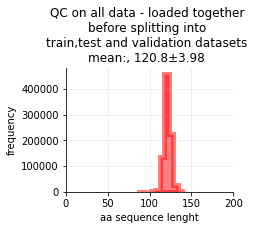

In [5]:
_, _ = load_and_prepare_the_AAseq_data(
    fname = 'LTSM_AAseq_vlen_data_dct.p',
    path_in=PATH_data_raw,
    path_out=PATH_data_interim,
    load_data_for_ml_dct =dict(
        file_types = organisms, 
        filenames_to_use=filenames_aa_seq_vlen, 
        test_size=0.15, 
        random_state=0, # decides on which samples will be selected to test subset
        verbose=True    
    )
)

__(B) aligned aa-sequence data__

-------------------------------------------------------------
loaded:  0 0 (357071,) human  -  human_train.txt
loaded:  0 1 (76515,) human  -  human_val.txt
loaded:  0 2 (76515,) human  -  human_test.txt
loaded:  1 0 (500000,) mouse  -  mouse_test.txt
total dimension:  (1010101, 2)  - demultiplexed, and with target
-------------------------------------------------------------
removed 24 duplicates

. train/validation data:  (858565, 2)
0    433597
1    424968
Name: target, dtype: int64

. test data:  (151512, 2)
0    76504
1    75008
Name: target, dtype: int64
-------------------------------------------------------------

-----------------------------------------------
QC on all data - loaded together
before splitting into
train,test and validation datasets
-----------------------------------------------
. shape: (858565,)
. unique el: (858565,)
. non-unique el: 0
. max nr of duplicates: None
. mean seq len:, 150.0±0.0
. examples


151512    --VQLVES-GGGVVQPGRSLRLSCAASE-FSFSS-----FGMHWVR...
151513    -EMQLLES-GGGLAQPGGSLRLSCAASG-FTFSN-----YWMHWVR...
Name: aa_seq, dtype: object

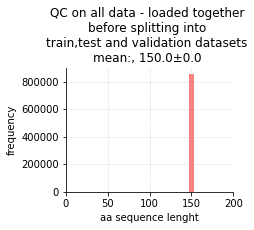

In [6]:
data, data_test = load_and_prepare_the_AAseq_data(
    fname = 'LTSM_AAseq_data_dct.p',
    path_in=PATH_data_raw,
    path_out=PATH_data_interim,
    load_data_for_ml_dct =dict(
        file_types = organisms, 
        filenames_to_use=filenames_aa_seq, 
        test_size=0.15, 
        random_state=0, # decides on which samples will be selected to test subset
        verbose=True    
    )
)



## Step 2. Use loaded data (aligned aa-sequences) to prepare the data for sklearn baseline models
* in notebook one (EDA), I observed large number of low-frequency aa that may be sequence or aligment errors, or simply generate to many dimensions in one-hot encoded data, with zero values at almost all the samples,  
* for these reasons I decided to remove infrequent aa, with custom made class transformer, 
* __the pipeline does the following:__
    - generate dataframe with column for each position in aligned data
    - evaluate each postions, and remove low frequency aa, eg singletons, or aa that are present in less then 1% of sequences, 
    - replace them with the most frequent aa or aligment gap
    - one-hot encode the data  
* __data organization__
    - the ssame pipeline will generate test, train and validation datasaved in dictorary
    - test and validaiton data will be generated with different randnr, 0-9, saved separately, 
    - it is done to save time later on while traingin the model, 
    - data frame with processed aa sequences are also saved so they can be used with LTSMs
    
__IMPORTANT COMMENT__
* after rewiewing the data with simple models, I decided to work only with the most conservative data preparation procedure for constructing model baseline, 
* it was done, also because of file size of onehote encoded data that were >2GB each, 

In [11]:
parameters = {
    # use aa that are present in >1% of sequenses ot min, 2 sequences
    'Processed_AAseq_1p2r':{
        "train_size":0.7,
        "prepare_aa_data_for_baseline":{'tr':1, 'min_nr':1}
    },
    # use aa that are present in >5% of sequenses ot min, 2 sequences
    'Processed_AAseq_5p2r':{
        "train_size":0.7,
        "prepare_aa_data_for_baseline":{'tr':5, 'min_nr':1}
    },
    # use aa that are present in >10% of sequenses ot min, 10 sequences
    'Processed_AAseq_10p2r':{
        "train_size":0.7,
        "prepare_aa_data_for_baseline":{'tr':10, 'min_nr':10}
    }
}


parameters = {
    # use aa that are present in >10% of sequenses ot min, 10 sequences
    'Processed_AAseq_10p10r':{
        "train_size":0.7,
        "prepare_aa_data_for_baseline":{'tr':10, 'min_nr':10}
    }
}



.....................................................................
dataset_name:  Processed_AAseq_10p10r
rand_nr: 0
params: {'train_size': 0.7, 'prepare_aa_data_for_baseline': {'tr': 10, 'min_nr': 10}}
.....................................................................

- PART 1 - CREATE TRAIN AND VALIDAITON SUBSETS

-----------------------------------------------
train subset
-----------------------------------------------
. shape: (600996,)
. unique el: (600996,)
. non-unique el: 0
. max nr of duplicates: None
. mean seq len:, 150.0±0.0
. examples


0    -EVQLVES-GGGFAQPGGSLGLSCAASG-FVFNT-----YLRHGVW...
1    -QVQLVQA-GAEVKTPGASVKVSCKGSG-YTFNK-----YGISGVR...
Name: aa_seq, dtype: object


-----------------------------------------------
validation subset
-----------------------------------------------
. shape: (257569,)
. unique el: (257569,)
. non-unique el: 0
. max nr of duplicates: None
. mean seq len:, 150.0±0.0
. examples


0    -QLQLVES-GGGVVQPGGSLRLSCVASG-FDFRS-----HDMHWVR...
1    -QVQLLQS-GSEVKKPGASVKVSCEISG-YTVTA-----LAMHWVR...
Name: aa_seq, dtype: object


-----------------------------------------------
test subset
-----------------------------------------------
. shape: (151512,)
. unique el: (151512,)
. non-unique el: 0
. max nr of duplicates: None
. mean seq len:, 150.0±0.0
. examples


0    -QIQLVQS-GPEVRKPGASVKVSCKASG-YTFSS-----YGISWVR...
1    -QVQLQQP-GAELVKPGASVKVSCKASG-YTFTS-----YWMHWVK...
Name: aa_seq, dtype: object


X.shape:  (303459, 150)
y.shape:  (303459,)


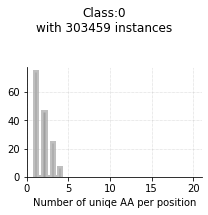


X.shape:  (600996, 150)
y.shape:  (600996,)


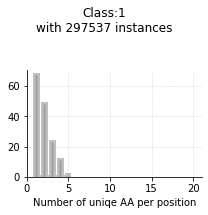

AA matrix shape:  (151512, 150)
AA matrix shape:  (257569, 150)

- PART 2 - create df, with each postiosn in different collumne and remove noise

train data: X.shape = (600996, 150), y.shape = (600996,)
valid data: X.shape = (257569, 150), y.shape = (257569,)
test data: X.shape = (151512, 150), y.shape = (151512,)
SAVING: Processed_AAseq_10p10r_expanded_v0_dct.p
PWD:  /Users/pawel/Desktop/activities/100__Projects/LTSM_for_Antibiodies/LTSM_for_Antibodies/data/interim


- PART 3 - ONE HOT ENCODING WITH sklearn transformer

train data: X.shape = (600996, 325), y.shape = (600996,)
valid data: X.shape = (257569, 325), y.shape = (257569,)
test data: X.shape = (151512, 325), y.shape = (151512,)
SAVING: Processed_AAseq_10p10r_onehotenc_v0_dct.p
PWD:  /Users/pawel/Desktop/activities/100__Projects/LTSM_for_Antibiodies/LTSM_for_Antibodies/data/interim




.....................................................................
dataset_name:  Processed_AAseq_10p10r
rand_nr: 1
params: {'train_size': 0

0    -EVQLVAS-GGVVVQPGGSLRLSCAACG-FPFVD-----FAIHWVR...
1    -QLQLQES-GPGLVKPSATLSLTCTVSG-GSISSS---SYYCGWIR...
Name: aa_seq, dtype: object


-----------------------------------------------
validation subset
-----------------------------------------------
. shape: (257569,)
. unique el: (257569,)
. non-unique el: 0
. max nr of duplicates: None
. mean seq len:, 150.0±0.0
. examples


0    -QVQLQQP-GAELVKPGASVKVSCKASG-YTFTS-----YWMHWVK...
1    -QVTLRES-GPTLVKPSQTLTLTCTFSG-VSLTAS---GMGVGWIR...
Name: aa_seq, dtype: object


-----------------------------------------------
test subset
-----------------------------------------------
. shape: (151512,)
. unique el: (151512,)
. non-unique el: 0
. max nr of duplicates: None
. mean seq len:, 150.0±0.0
. examples


0    -QIQLVQS-GPEVRKPGASVKVSCKASG-YTFSS-----YGISWVR...
1    -QVQLQQP-GAELVKPGASVKVSCKASG-YTFTS-----YWMHWVK...
Name: aa_seq, dtype: object


X.shape:  (303265, 150)
y.shape:  (303265,)


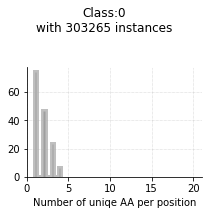


X.shape:  (600996, 150)
y.shape:  (600996,)


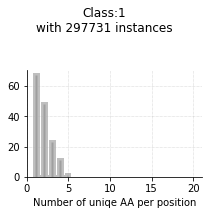

AA matrix shape:  (151512, 150)
AA matrix shape:  (257569, 150)

- PART 2 - create df, with each postiosn in different collumne and remove noise

train data: X.shape = (600996, 150), y.shape = (600996,)
valid data: X.shape = (257569, 150), y.shape = (257569,)
test data: X.shape = (151512, 150), y.shape = (151512,)
SAVING: Processed_AAseq_10p10r_expanded_v1_dct.p
PWD:  /Users/pawel/Desktop/activities/100__Projects/LTSM_for_Antibiodies/LTSM_for_Antibodies/data/interim


- PART 3 - ONE HOT ENCODING WITH sklearn transformer

train data: X.shape = (600996, 325), y.shape = (600996,)
valid data: X.shape = (257569, 325), y.shape = (257569,)
test data: X.shape = (151512, 325), y.shape = (151512,)
SAVING: Processed_AAseq_10p10r_onehotenc_v1_dct.p
PWD:  /Users/pawel/Desktop/activities/100__Projects/LTSM_for_Antibiodies/LTSM_for_Antibodies/data/interim




.....................................................................
dataset_name:  Processed_AAseq_10p10r
rand_nr: 2
params: {'train_size': 0

0    -EVQLQQS-GPELVKPGASVRISCKASG-YTFTS-----YWMQWVK...
1    -QVQLLQS-GPELVKPGASVKISCKASG-YSFTD-----YYMNWVK...
Name: aa_seq, dtype: object


-----------------------------------------------
validation subset
-----------------------------------------------
. shape: (257569,)
. unique el: (257569,)
. non-unique el: 0
. max nr of duplicates: None
. mean seq len:, 150.0±0.0
. examples


0    -EVQLVES-GGGLVKPGGSLKLSCAASG-FTFSS-----YTMSWVR...
1    -EVQLVES-GGGMVQPGGSLRLSCAASG-FTFSD-----HYMDWVR...
Name: aa_seq, dtype: object


-----------------------------------------------
test subset
-----------------------------------------------
. shape: (151512,)
. unique el: (151512,)
. non-unique el: 0
. max nr of duplicates: None
. mean seq len:, 150.0±0.0
. examples


0    -QIQLVQS-GPEVRKPGASVKVSCKASG-YTFSS-----YGISWVR...
1    -QVQLQQP-GAELVKPGASVKVSCKASG-YTFTS-----YWMHWVK...
Name: aa_seq, dtype: object


X.shape:  (303457, 150)
y.shape:  (303457,)


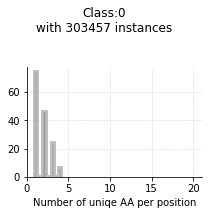


X.shape:  (600996, 150)
y.shape:  (600996,)


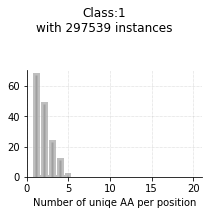

AA matrix shape:  (151512, 150)
AA matrix shape:  (257569, 150)

- PART 2 - create df, with each postiosn in different collumne and remove noise

train data: X.shape = (600996, 150), y.shape = (600996,)
valid data: X.shape = (257569, 150), y.shape = (257569,)
test data: X.shape = (151512, 150), y.shape = (151512,)
SAVING: Processed_AAseq_10p10r_expanded_v2_dct.p
PWD:  /Users/pawel/Desktop/activities/100__Projects/LTSM_for_Antibiodies/LTSM_for_Antibodies/data/interim


- PART 3 - ONE HOT ENCODING WITH sklearn transformer

train data: X.shape = (600996, 325), y.shape = (600996,)
valid data: X.shape = (257569, 325), y.shape = (257569,)
test data: X.shape = (151512, 325), y.shape = (151512,)
SAVING: Processed_AAseq_10p10r_onehotenc_v2_dct.p
PWD:  /Users/pawel/Desktop/activities/100__Projects/LTSM_for_Antibiodies/LTSM_for_Antibodies/data/interim




.....................................................................
dataset_name:  Processed_AAseq_10p10r
rand_nr: 3
params: {'train_size': 0

0    -EVQLQQS-VAELVRPGASVKLSCTASG-FNIKN-----TYMHWVK...
1    -EVQLQQS-GAELVRPGASVKLSCTASG-FNIKD-----DYMHWVK...
Name: aa_seq, dtype: object


-----------------------------------------------
validation subset
-----------------------------------------------
. shape: (257569,)
. unique el: (257569,)
. non-unique el: 0
. max nr of duplicates: None
. mean seq len:, 150.0±0.0
. examples


0    -QVQLVES-GGGVVQPGRSLRLACAASG-FTFSS-----YAMHWVR...
1    -QVQLQQS-GAELVKPGASVKLSCTASG-FNIKD-----YYMHWVK...
Name: aa_seq, dtype: object


-----------------------------------------------
test subset
-----------------------------------------------
. shape: (151512,)
. unique el: (151512,)
. non-unique el: 0
. max nr of duplicates: None
. mean seq len:, 150.0±0.0
. examples


0    -QIQLVQS-GPEVRKPGASVKVSCKASG-YTFSS-----YGISWVR...
1    -QVQLQQP-GAELVKPGASVKVSCKASG-YTFTS-----YWMHWVK...
Name: aa_seq, dtype: object


X.shape:  (303941, 150)
y.shape:  (303941,)


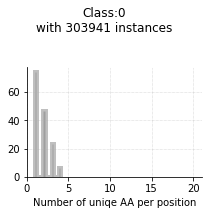


X.shape:  (600996, 150)
y.shape:  (600996,)


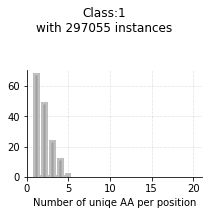

AA matrix shape:  (151512, 150)
AA matrix shape:  (257569, 150)

- PART 2 - create df, with each postiosn in different collumne and remove noise

train data: X.shape = (600996, 150), y.shape = (600996,)
valid data: X.shape = (257569, 150), y.shape = (257569,)
test data: X.shape = (151512, 150), y.shape = (151512,)
SAVING: Processed_AAseq_10p10r_expanded_v3_dct.p
PWD:  /Users/pawel/Desktop/activities/100__Projects/LTSM_for_Antibiodies/LTSM_for_Antibodies/data/interim


- PART 3 - ONE HOT ENCODING WITH sklearn transformer

train data: X.shape = (600996, 325), y.shape = (600996,)
valid data: X.shape = (257569, 325), y.shape = (257569,)
test data: X.shape = (151512, 325), y.shape = (151512,)
SAVING: Processed_AAseq_10p10r_onehotenc_v3_dct.p
PWD:  /Users/pawel/Desktop/activities/100__Projects/LTSM_for_Antibiodies/LTSM_for_Antibodies/data/interim




In [12]:
parameters = {
    # use aa that are present in >1% of sequenses ot min, 2 sequences
    'Processed_AAseq_1p2r':{
        "train_size":0.7,
        "prepare_aa_data_for_baseline":{'tr':1, 'min_nr':1}
    },
    # use aa that are present in >5% of sequenses ot min, 2 sequences
    'Processed_AAseq_5p2r':{
        "train_size":0.7,
        "prepare_aa_data_for_baseline":{'tr':5, 'min_nr':1}
    },
    # use aa that are present in >10% of sequenses ot min, 10 sequences
    'Processed_AAseq_10p2r':{
        "train_size":0.7,
        "prepare_aa_data_for_baseline":{'tr':10, 'min_nr':10}
    }
}


parameters = {
    # use aa that are present in >10% of sequenses ot min, 10 sequences
    'Processed_AAseq_10p10r':{
        "train_size":0.7,
        "prepare_aa_data_for_baseline":{'tr':10, 'min_nr':10}
    }
}



data_preprocessing_pipeline(
    data = data,
    data_test = data_test,
    random_nr_list = [0, 1, 2, 3],
    path=PATH_data_interim,
    parameters = parameters, 
    verbose=True
)